In [425]:
import pickle
import numpy as np
np.seterr(divide='ignore')

import awkward
import awkward as ak
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import uproot
import boost_histogram as bh
import mplhep
import mplhep as hep
import glob
import os
import vector
import shutil
from matplotlib.lines import Line2D
import numba
import tqdm

mplhep.style.use("CMS")

In [2]:
matplotlib.rcParams['axes.labelsize'] = 35
legend_fontsize = 30
sample_label_fontsize = 30
addtext_fontsize = 25

jet_label_coords = 0.02, 0.82
jet_label_coords_single = 0.02, 0.86
sample_label_coords = 0.02, 0.96

min_rj_pt = 8
min_fatjet_pt = 150
jet_label_ak4 = "AK4 jets"
jet_label_ak8 = "AK8 jets, $p_{T}$ > "+str(min_fatjet_pt)+ " GeV"
jet_label_corr = "Corr. jet "
jet_label_raw = "Raw jet "
reco_gen_ratio = "Rec. / Gen."

default_cycler = plt.rcParams['axes.prop_cycle']
pf_color = list(default_cycler)[1]["color"]
mlpf_color = list(default_cycler)[2]["color"]

pf_linestyle = "-."
mlpf_linestyle = "-"

In [423]:
import sys

sys.path += ["../../mlpf/plotting/"]
sys.path += ["../../mlpf/"]
sys.path += ["../../local/lib/python3.11/site-packages/"]

import plot_utils
import jet_utils
import correctionlib

from plot_utils import ELEM_LABELS_CMS, ELEM_NAMES_CMS
from plot_utils import CLASS_LABELS_CMS, CLASS_NAMES_CMS
from plot_utils import experiment_label, sample_label

# def cms_label(ax):
#     return experiment_label(ax, experiment="CMS", tag1="Simulation Preliminary", tag2="Run 3 (13.6 TeV)", x1=0.13)

def cms_label(ax):    
    hep.cms.lumitext("Run 3 (13.6 TeV)", ax=ax, fontsize=30)
    hep.cms.text("Simulation", ax=ax, fontsize=25)

In [4]:
# fi = uproot.open("/scratch/local/joosep/mlpf/results/cms/CMSSW_15_0_5_mlpf_v2.5.0_p01_603dc5/TTbar_PU_mlpfpu/step4_NANO_btv_1.root").get("Events")
# for k in sorted(fi.keys()):
#     print(k)

In [231]:
def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    return h1

def load_nano(fn):
    # print(fn)
    tt = uproot.open(fn).get("Events")
    ret = {}
    for k in [
#         "Jet_pt",
#         "Jet_eta",
#         "Jet_phi",
#         "Jet_genJetIdx",
#         "Jet_rawFactor",

        # jet ID variables
        # "Jet_nConstituents",
        # "Jet_nElectrons",
        # "Jet_nMuons",
        # "Jet_hfEmEF",
        # "Jet_hfHEF",
        # "Jet_muEF",

        "Jet_chMultiplicity",
        "Jet_neMultiplicity",
        "Jet_chEmEF",
        "Jet_chHEF",
        "Jet_neEmEF",
        "Jet_neHEF",
        "Jet_neHadMultiplicity",
        
#         "FatJet_pt", "FatJet_eta", "FatJet_genJetAK8Idx", "FatJet_rawFactor",
#         "GenJet_pt", "GenJet_eta", "GenJet_phi",
#         "GenJetAK8_pt", "GenJetAK8_eta",
        "GenMET_pt", "GenMET_phi",
        "PFMET_pt", "PFMET_phi",
        "PuppiMET_pt", "PuppiMET_phi",
        "RawPFMET_pt", "RawPFMET_phi",
#         "Pileup_nPU", "Pileup_nTrueInt",    
    ]:
        ret[k] = tt.arrays(k)[k]
        
    # to make mT plot        
    msk_genmuon = (abs(tt["GenPart_pdgId"].array()) == 13) & (tt["GenPart_status"].array() == 1)

    for p4var in ["pt", "eta", "phi", "mass"]:
        ret[f"GenMuon_{p4var}"] = tt[f"GenPart_{p4var}"].array()[msk_genmuon]
        
#     for p4var in ["pt", "eta", "phi", "energy"]:
        ret[f"PFMuon_{p4var}"] = tt[f"Muon_{p4var}"].array()
        
    return [ret, ]

def varbins(*args):
    newlist = []
    for arg in args[:-1]:
        newlist.append(arg[:-1])
    newlist.append(args[-1])
    return np.concatenate(newlist)

def get_hist_and_merge(files, histname):
    hists = []
    for fn in files:
        fi = uproot.open(fn)
        h = fi[histname].to_boost()
        hists.append(h)
    return sum(hists[1:], hists[0])

from scipy.optimize import curve_fit

def Gauss(x, a, x0, sigma):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))

def midpoints(x):
    return (x[1:] + x[:-1]) / 2

In [328]:
# folder = "PhotonJet_noPU_13p6"
# physics_process = "cms_pf_photonjet_nopu"

folder = "TTbar_PU_13p6"
physics_process = "cms_pf_ttbar"

if physics_process in ["cms_pf_qcd_nopu", "cms_pf_qcd"]:
    jet_bins = varbins(np.linspace(20, 100, 21), np.linspace(100, 200, 5), np.linspace(200, 1000, 5))
    fatjet_bins = varbins(np.linspace(200, 1000, 5))
    met_bins = varbins(np.linspace(0, 150, 21), np.linspace(150, 500, 5))
    pt_bins_for_pu = [(0, 30), (30, 60), (60, 100), (100, 200), (200,5000)]

if physics_process == "cms_pf_ttbar" or physics_process == "cms_pf_ttbar_nopu":
    jet_bins = varbins(np.linspace(20, 100, 21), np.linspace(100, 250, 5))
    fatjet_bins = varbins(np.linspace(100, 400, 5))
    met_bins = varbins(np.linspace(0, 150, 21), np.linspace(150, 250, 5))
    pt_bins_for_pu = [(0, 30), (30, 60), (60, 100), (100, 200), (200,5000)]

if physics_process.startswith("cms_pf_photonjet"):
    jet_bins = varbins(np.linspace(20, 60, 21), np.linspace(60, 120, 2))
    fatjet_bins = varbins(np.linspace(0, 1000, 2))
    met_bins = varbins(np.linspace(0, 200, 41))
    pt_bins_for_pu = [(0, 30), (30, 60), (60, 100)]

jet_bins_eta = np.linspace(-5, 5, 81)
outpath = "cmssw/{}".format(folder)
shutil.rmtree(outpath, ignore_errors=True)
os.makedirs(outpath)

In [329]:
! ls ../../data/CMSSW_15_0_5_mlpf_v2.6.0pre1_p05_ccd0c7/cuda_False/

QCD_noPU_13p6_mlpfpu   TTbar_noPU_13p6_mlpfpu TTbar_PU_13p6_mlpfpu
QCD_noPU_13p6_pf       TTbar_noPU_13p6_pf     TTbar_PU_13p6_pf


In [330]:
#path = "/local/joosep/mlpf/results/cms/CMSSW_15_0_5_mlpf_v2.5.0_p01_f8ae2f/cuda_False/"
# path = "/scratch/persistent/joosep/mlpf/results/cms/CMSSW_15_0_5_mlpf_v2.5.0_p01_f8ae2f/cuda_False/"
path = "../../data/CMSSW_15_0_5_mlpf_v2.6.0pre1_p05_ccd0c7/cuda_False/"
pf_files = glob.glob("{}/{}_pf/step4_NANO_jme_*.root".format(path, folder))
mlpf_files = glob.glob("{}/{}_mlpfpu/step4_NANO_jme_*.root".format(path, folder))
#mlpf_new_files = glob.glob("/scratch/local/joosep/mlpf/results/cms/CMSSW_15_0_5_mlpf_v2.5.0_p01/{}_mlpfpu/step4_NANO_btv_*.root".format(folder))

pf_files_d = {os.path.basename(fn): fn for fn in pf_files}
mlpf_files_d = {os.path.basename(fn): fn for fn in mlpf_files}

In [349]:
len(pf_files_d), len(mlpf_files_d)#, len(mlpf_new_files)

(2050, 2050)

In [350]:
common_files = list(set(pf_files_d.keys()).intersection(set(mlpf_files_d.keys())))
# common_files = common_files[:1000]
len(common_files)

2050

In [351]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
def load_multiprocess(files, max_workers=None):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm.tqdm(executor.map(load_nano, files), total=len(files)))
    successful_results = [r for r in results if r is not None]
    return awkward.concatenate(successful_results)

    return awkward.concatenate(successful_results)

def load_singleprocess(files):
    results = []
    for i, fn in enumerate(tqdm.tqdm(files)):
        try:
            ret = load_nano(fn)
            results.append(ret)
        except Exception as e:
            print("could not process " + fn)
    return ak.concatenate(results)

In [352]:
# data_baseline = load_multiprocess([pf_files_d[fn] for fn in common_files], 16)
# data_mlpf =  load_multiprocess([mlpf_files_d[fn] for fn in common_files], 16)

data_baseline = load_singleprocess([pf_files_d[fn] for fn in common_files])
data_mlpf =  load_singleprocess([mlpf_files_d[fn] for fn in common_files])

#data_mlpf_new = awkward.Array(sum([load_nano(mlpf_new_files_d[fn]) for fn in common_files], []))

    data_baseline_14 = load_multiprocess([pf_files_d[fn] for fn in common_files], 8)
    data_mlpf_14 =  load_multiprocess([mlpf_files_d[fn] for fn in common_files], 8)
    
    data_baseline_14 = awkward.Array({k: awkward.flatten(data_baseline_14[k], axis=1) for k in data_baseline_14.fields})
    data_mlpf_14 = awkward.Array({k: awkward.flatten(data_mlpf_14[k], axis=1) for k in data_mlpf_14.fields})
    has_14TeV = True

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2050/2050 [15:51<00:00,  2.16it/s]


In [ ]:
def apply_dz(data):
    abs_dz = np.abs(data["GenVtx_z"] - data["PV_z"])
    mask_dz = abs_dz<0.2
    return data[mask_dz]

## Jets

### Jet $p_T$ spectrum

In [ ]:
data_baseline["Jet_pt_raw"] = data_baseline["Jet_pt"]*(1.0 - data_baseline["Jet_rawFactor"])
data_mlpf["Jet_pt_raw"] = data_mlpf["Jet_pt"]*(1.0 - data_mlpf["Jet_rawFactor"])

data_baseline["FatJet_pt_raw"] = data_baseline["FatJet_pt"]*(1.0 - data_baseline["FatJet_rawFactor"])
data_mlpf["FatJet_pt_raw"] = data_mlpf["FatJet_pt"]*(1.0 - data_mlpf["FatJet_rawFactor"])

if has_14TeV:
    data_baseline_14["Jet_pt_raw"] = data_baseline_14["Jet_pt"]*(1.0 - data_baseline_14["Jet_rawFactor"])
    data_mlpf_14["Jet_pt_raw"] = data_mlpf_14["Jet_pt"]*(1.0 - data_mlpf_14["Jet_rawFactor"])
    
    data_baseline_14["FatJet_pt_raw"] = data_baseline_14["FatJet_pt"]*(1.0 - data_baseline_14["FatJet_rawFactor"])
    data_mlpf_14["FatJet_pt_raw"] = data_mlpf_14["FatJet_pt"]*(1.0 - data_mlpf_14["FatJet_rawFactor"])

In [ ]:
data_baseline = apply_dz(data_baseline)
data_mlpf = apply_dz(data_mlpf)

if has_14TeV:
    data_baseline_14 = apply_dz(data_baseline_14)
    data_mlpf_14 = apply_dz(data_mlpf_14)

In [ ]:
# Load pre-derived corrections (for now, these are not used in the responses)
corr_pf = correctionlib.CorrectionSet.from_file("../../corrections/pf_ak4.json")
corr_mlpf = correctionlib.CorrectionSet.from_file("../../corrections/mlpf.json")

corr_pf_ak8 = correctionlib.CorrectionSet.from_file("../../corrections/pf_ak8.json")
corr_mlpf_ak8 = correctionlib.CorrectionSet.from_file("../../corrections/mlpf_ak8.json")

In [ ]:
list(corr_pf.keys()), list(corr_pf_ak8.keys())

In [ ]:
list(corr_mlpf.keys()), list(corr_mlpf_ak8.keys())

In [ ]:
c = corr_pf["Summer22Run3_MC_L2Relative_AK4PUPPI"]

In [ ]:
xs = np.linspace(0,500,100)
ys1 = [corr_pf["Summer22Run3_MC_L2Relative_AK4PUPPI"].evaluate(0.0, x) for x in xs]
ys2 = [corr_mlpf["Summer22Run3_MC_L2Relative_AK4MLPFPU"].evaluate(0.0, x) for x in xs]
plt.plot(xs, ys1, label="PF")
plt.plot(xs, ys2, label="MLPF")
plt.legend()
plt.xlabel("jet raw pt")

In [ ]:
data_baseline["Jet_pt_corr"] =  data_baseline["Jet_pt_raw"]*corr_pf["Summer22Run3_MC_L2Relative_AK4PUPPI"].evaluate(data_baseline["Jet_eta"], data_baseline["Jet_pt_raw"])
data_mlpf["Jet_pt_corr"] =  data_mlpf["Jet_pt_raw"]*corr_mlpf["Summer22Run3_MC_L2Relative_AK4MLPFPU"].evaluate(data_mlpf["Jet_eta"], data_mlpf["Jet_pt_raw"])

data_baseline["FatJet_pt_corr"] =  data_baseline["FatJet_pt_raw"]*corr_pf_ak8["Summer22Run3_MC_L2Relative_AK8PUPPI"].evaluate(data_baseline["FatJet_eta"], data_baseline["FatJet_pt_raw"])
data_mlpf["FatJet_pt_corr"] =  data_mlpf["FatJet_pt_raw"]*corr_mlpf_ak8["Summer22Run3_MC_L2Relative_AK8MLPFPU"].evaluate(data_mlpf["FatJet_eta"], data_mlpf["FatJet_pt_raw"])

if has_14TeV:
    data_baseline_14["Jet_pt_corr"] =  data_baseline_14["Jet_pt_raw"]*corr_pf["Summer22Run3_MC_L2Relative_AK4PUPPI"].evaluate(data_baseline_14["Jet_eta"], data_baseline_14["Jet_pt_raw"])
    data_mlpf_14["Jet_pt_corr"] =  data_mlpf_14["Jet_pt_raw"]*corr_mlpf["Summer22Run3_MC_L2Relative_AK4MLPFPU"].evaluate(data_mlpf_14["Jet_eta"], data_mlpf_14["Jet_pt_raw"])
    
    data_baseline_14["FatJet_pt_corr"] =  data_baseline_14["FatJet_pt_raw"]*corr_pf_ak8["Summer22Run3_MC_L2Relative_AK8PUPPI"].evaluate(data_baseline_14["FatJet_eta"], data_baseline_14["FatJet_pt_raw"])
    data_mlpf_14["FatJet_pt_corr"] =  data_mlpf_14["FatJet_pt_raw"]*corr_mlpf_ak8["Summer22Run3_MC_L2Relative_AK8MLPFPU"].evaluate(data_mlpf_14["FatJet_eta"], data_mlpf_14["FatJet_pt_raw"])

In [ ]:
np.min(data_baseline["GenJet_pt"]), np.min(data_baseline["Jet_pt_corr"]), np.min(data_baseline["Jet_pt_raw"])

In [ ]:
np.min(data_baseline["GenJetAK8_pt"]), np.min(data_baseline["FatJet_pt_corr"]), np.min(data_baseline["FatJet_pt_raw"])

In [ ]:
@numba.njit
def deltaphi_nb(phi1, phi2):
    diff = phi1 - phi2
    return np.arctan2(np.sin(diff), np.cos(diff))

@numba.njit
def deltar_nb(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = deltaphi_nb(phi1, phi2)
    return np.sqrt(deta**2 + dphi**2)

@numba.njit
def match_jets_nb(j1_eta, j2_eta, j1_phi, j2_phi, deltar_cut):
    assert(len(j1_eta)==len(j2_eta))
    assert(len(j1_phi)==len(j2_phi))
    assert(len(j1_eta)==len(j1_phi))
    iev = len(j1_eta)
    jet_inds_1_ev = []
    jet_inds_2_ev = []
    drs_ev = []
    for ev in range(iev):
        jet_inds_1 = []
        jet_inds_2 = []
        drs = []

        #algo from http://cms.cern.ch/iCMS/jsp/openfile.jsp?tp=draft&files=AN2023_061_v2.pdf, section 3.2 (jet matching)
        while True:
            #no jets in this event, go to next event
            if len(j1_eta[ev])==0 or len(j2_eta[ev])==0:
                jet_inds_1_ev.append(jet_inds_1)
                jet_inds_2_ev.append(jet_inds_2)
                drs_ev.append(drs)
                break

            #initialize all pairs
            drs_jets = 999*np.ones((len(j1_eta[ev]), len(j2_eta[ev])), dtype=np.float64)

            # loop over all reco-gen pairs
            # loop over the first jet collection
            for ij1 in range(len(j1_eta[ev])):
                #check if jet was already used
                if ij1 in jet_inds_1:
                    continue
                    
                # loop over the other jet collection
                for ij2 in range(len(j2_eta[ev])):
                    #check if jet was already used
                    if ij2 in jet_inds_2:
                        continue

                    #set the delta R of this pair
                    eta1 = j1_eta[ev][ij1]
                    eta2 = j2_eta[ev][ij2]
                    phi1 = j1_phi[ev][ij1]
                    phi2 = j2_phi[ev][ij2]
                    dr = deltar_nb(eta1, phi1, eta2, phi2)
                    drs_jets[ij1, ij2] = dr

            #find the pair with the lowest delta R
            flat_index = np.argmin(drs_jets)
            num_rows, num_cols = drs_jets.shape
            ij1_min = flat_index // num_cols
            ij2_min = flat_index % num_cols

            #choose this pair, mark these jets as used
            jet_inds_1.append(ij1_min)
            jet_inds_2.append(ij2_min)
            drs.append(drs_jets[ij1_min, ij2_min])
            
            #if all jets were matched from either collection, abort the loop and go to next event
            if len(jet_inds_1) == len(j1_eta[ev]) or len(jet_inds_2) == len(j2_eta[ev]):
                jet_inds_1_ev.append(jet_inds_1)
                jet_inds_2_ev.append(jet_inds_2)
                drs_ev.append(drs)
                break
    return jet_inds_1_ev, jet_inds_2_ev, drs_ev

In [ ]:
plt.hist(awkward.flatten(data_baseline["Jet_neMultiplicity"][np.abs(data_baseline["Jet_eta"])>3]), bins=np.linspace(0,10,11), histtype="step")
plt.hist(awkward.flatten(data_mlpf["Jet_neMultiplicity"][np.abs(data_mlpf["Jet_eta"])>3]), bins=np.linspace(0,10,11), histtype="step")
plt.yscale("log")

In [ ]:
plt.hist(awkward.flatten(data_baseline["Jet_neEmEF"][np.abs(data_baseline["Jet_eta"])>3]), bins=np.linspace(0,1,101), histtype="step")
plt.hist(awkward.flatten(data_mlpf["Jet_neEmEF"][np.abs(data_mlpf["Jet_eta"])>3]), bins=np.linspace(0,1,101), histtype="step")
plt.yscale("log")

In [ ]:
def compute_response(data, jet_coll="Jet", genjet_coll="GenJet", deltar_cut=0.2, tag="pf"):
    #get the matched recojet and genjet indices
    rj_idx, gj_idx, drs = match_jets_nb(data[jet_coll+"_eta"], data[genjet_coll+"_eta"], data[jet_coll+"_phi"], data[genjet_coll+"_phi"], deltar_cut)
    rj_idx = awkward.Array(rj_idx)
    gj_idx = awkward.Array(gj_idx)
    drs = awkward.Array(drs)
    
    #sort by genjet pt, pick leading 3 gen jets
    pair_sort = awkward.argsort(data[genjet_coll+"_pt"][gj_idx], axis=1, ascending=False)[:, :3]

    #sort by leading recojets, NOT USED as it can bias the result towards good reco jets
    #pair_sort = awkward.argsort(data[jet_coll+"_pt_raw"][rj_idx], axis=1, ascending=False)[:, :3]

    gj_pt = data[genjet_coll+"_pt"][gj_idx][pair_sort]
    gj_pt_unfiltered = data[genjet_coll+"_pt"][gj_idx]
    gj_eta = data[genjet_coll+"_eta"][gj_idx][pair_sort]
    gj_eta_unfiltered = data[genjet_coll+"_eta"][gj_idx]
    rj_pt_corr_unfiltered = data[jet_coll+"_pt_corr"][rj_idx]
    rj_pt_corr = data[jet_coll+"_pt_corr"][rj_idx][pair_sort]
    rj_pt_raw = data[jet_coll+"_pt_raw"][rj_idx][pair_sort]
    rj_pt_raw_unfiltered = data[jet_coll+"_pt_raw"][rj_idx]
    rj_eta = data[jet_coll+"_eta"][rj_idx][pair_sort]
    rj_eta_unfiltered = data[jet_coll+"_eta"][rj_idx]
    dr = drs[pair_sort]

    #deltaR mask applied AFTER the leading 3 genjets are selected, per the JME AN
    mask_top3 = (dr<deltar_cut) #cut on top 3 jets
    mask = (drs<deltar_cut) #cut on all jets
    
    #pply partial jet ID to get rid of double peak in response
    if jet_coll == "Jet":
        mask_top3 = mask_top3 & (
            (
                (data["Jet_neMultiplicity"][rj_idx][pair_sort]>1)
            ) | 
            (np.abs(data["Jet_eta"][rj_idx][pair_sort])<3)
        )
        mask = mask & (
            (
                (data["Jet_neMultiplicity"][rj_idx]>1)
            ) | 
            (np.abs(data["Jet_eta"][rj_idx])<3)
        )

    response_corr = (rj_pt_corr/gj_pt)
    response_raw = (rj_pt_raw/gj_pt)
    return {
        "response": response_corr[mask_top3],
        "response_raw": response_raw[mask_top3],
        "dr": dr[mask_top3],
        jet_coll+"_pt_corr": rj_pt_corr[mask_top3],
        jet_coll+"_pt_raw": rj_pt_raw[mask_top3],
        jet_coll+"_eta": rj_eta[mask_top3],
        genjet_coll+"_pt": gj_pt[mask_top3],
        genjet_coll+"_eta": gj_eta[mask_top3],
        
        #these are stored without choosing the 3 hardest genjets, to compute the efficiency and purity
        jet_coll+"_pt_corr_unfiltered": rj_pt_corr_unfiltered[mask],
        jet_coll+"_pt_raw_unfiltered": rj_pt_raw_unfiltered[mask],
        jet_coll+"_eta_unfiltered": rj_eta_unfiltered[mask],
        genjet_coll+"_pt_unfiltered": gj_pt_unfiltered[mask],
        genjet_coll+"_eta_unfiltered": gj_eta_unfiltered[mask]
    }

In [ ]:
resp_pf_ak4 = compute_response(data_baseline, jet_coll="Jet", genjet_coll="GenJet", deltar_cut=0.2)
resp_mlpf_ak4 = compute_response(data_mlpf, jet_coll="Jet", genjet_coll="GenJet", deltar_cut=0.2, tag="mlpf")

if has_14TeV:
    resp_pf_ak4_14tev = compute_response(data_baseline_14, jet_coll="Jet", genjet_coll="GenJet", deltar_cut=0.2)
    resp_mlpf_ak4_14tev = compute_response(data_mlpf_14, jet_coll="Jet", genjet_coll="GenJet", deltar_cut=0.2, tag="mlpf")

In [ ]:
resp_pf_ak8 = compute_response(data_baseline, jet_coll="FatJet", genjet_coll="GenJetAK8", deltar_cut=0.4)
resp_mlpf_ak8 = compute_response(data_mlpf, jet_coll="FatJet", genjet_coll="GenJetAK8", deltar_cut=0.4, tag="mlpf")

In [ ]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

msk_jet_gen = (
    (data_baseline["GenJet_pt"]>min_rj_pt)
    #& ((np.abs(data_baseline["GenJet_eta"])<3))
)

msk_jet_pf = (
    (data_baseline["Jet_pt_raw"]>min_rj_pt)
    & ((data_baseline["Jet_neMultiplicity"]>1) | (np.abs(data_baseline["Jet_eta"])<3))
    #& ((np.abs(data_baseline["Jet_eta"])<3))
)
msk_jet_mlpf = (
    (data_mlpf["Jet_pt_raw"]>min_rj_pt)
    & ((data_mlpf["Jet_neMultiplicity"]>1) | (np.abs(data_mlpf["Jet_eta"])<3))
    #& ((np.abs(data_mlpf["Jet_eta"])<3))
)

h0 = to_bh(awkward.flatten(data_baseline["GenJet_pt"][msk_jet_gen]), jet_bins)
h1 = to_bh(awkward.flatten(data_baseline["Jet_pt_raw"][msk_jet_pf]), jet_bins)
h2 = to_bh(awkward.flatten(data_mlpf["Jet_pt_raw"][msk_jet_mlpf]), jet_bins)

plt.sca(a0)
x0 = mplhep.histplot(h0, histtype="step", lw=2, label="Gen.", binwnorm=1.0, ls="--")
x1 = mplhep.histplot(h1, histtype="step", lw=2, label="PF-PUPPI", binwnorm=1.0, ls=pf_linestyle)
x2 = mplhep.histplot(h2, histtype="step", lw=2, label=mlpf_label, binwnorm=1.0, ls=mlpf_linestyle)

# plt.xscale("log")
plt.yscale("log")
cms_label(a0)
sample_label(a0, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
a0.text(jet_label_coords[0], jet_label_coords[1], jet_label_ak4, transform=a0.transAxes, fontsize=addtext_fontsize)
handles, labels = a0.get_legend_handles_labels()
handles = [x0[0].stairs, x1[0].stairs, x2[0].stairs]
a0.legend(handles, labels, loc=(0.5, 0.5), fontsize=legend_fontsize)
plt.ylim(10, a0.get_ylim()[1]*1000)
plt.ylabel("Count")

plt.sca(a1)
mplhep.histplot(h0 / h0, histtype="step", lw=2, ls="--")
mplhep.histplot(h1 / h0, histtype="step", lw=2, ls=pf_linestyle)
mplhep.histplot(h2 / h0, histtype="step", lw=2, ls=mlpf_linestyle)
#mplhep.histplot(h3 / h0, histtype="step", lw=2, ls="-")
plt.ylim(0.8, 1.2)
plt.ylabel(reco_gen_ratio)
plt.xlabel(jet_label_raw + plot_utils.labels["pt_ptcl"])

plt.xscale("log")

plt.xlim(min(jet_bins), max(jet_bins))
plt.savefig("{}/ak4_jet_pt_raw.pdf".format(outpath))

In [ ]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

h0 = to_bh(awkward.flatten(data_baseline["GenJet_pt"][msk_jet_gen]), jet_bins)
h1 = to_bh(awkward.flatten(data_baseline["Jet_pt_corr"][msk_jet_pf]), jet_bins)
h2 = to_bh(awkward.flatten(data_mlpf["Jet_pt_corr"][msk_jet_mlpf]), jet_bins)
#h3 = to_bh(awkward.flatten(data_mlpf_new["Jet_pt_raw"]), jet_bins)

plt.sca(a0)
x0 = mplhep.histplot(h0, histtype="step", lw=2, label="Gen.", binwnorm=1.0, ls="--")
x1 = mplhep.histplot(h1, histtype="step", lw=2, label="PF-PUPPI", binwnorm=1.0, ls=pf_linestyle)
x2 = mplhep.histplot(h2, histtype="step", lw=2, label=mlpf_label, binwnorm=1.0, ls=mlpf_linestyle)
#x3 = mplhep.histplot(h3, histtype="step", lw=2, label="MLPF-PU p<0.1", binwnorm=1.0, ls="-")

# plt.xscale("log")
plt.yscale("log")
cms_label(a0)
sample_label(a0, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
a0.text(jet_label_coords[0], jet_label_coords[1], jet_label_ak4, transform=a0.transAxes, fontsize=addtext_fontsize)
handles, labels = a0.get_legend_handles_labels()
handles = [x0[0].stairs, x1[0].stairs, x2[0].stairs]
a0.legend(handles, labels, loc=(0.5, 0.5), fontsize=legend_fontsize)
plt.ylim(10, a0.get_ylim()[1]*1000)
plt.ylabel("Count")

plt.sca(a1)
mplhep.histplot(h0 / h0, histtype="step", lw=2, ls="--")
mplhep.histplot(h1 / h0, histtype="step", lw=2, ls=pf_linestyle)
mplhep.histplot(h2 / h0, histtype="step", lw=2, ls=mlpf_linestyle)
#mplhep.histplot(h3 / h0, histtype="step", lw=2, ls="-")
plt.ylim(0.8, 1.2)
plt.ylabel(reco_gen_ratio)
plt.xlabel(jet_label_corr + plot_utils.labels["pt_ptcl"])

plt.xscale("log")

plt.xlim(min(jet_bins), max(jet_bins))
plt.savefig("{}/ak4_jet_pt.pdf".format(outpath))

In [ ]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)
h0 = to_bh(awkward.flatten(data_baseline["GenJet_eta"][msk_jet_gen]), jet_bins_eta)
h1 = to_bh(awkward.flatten(data_baseline["Jet_eta"][msk_jet_pf]), jet_bins_eta)
h2 = to_bh(awkward.flatten(data_mlpf["Jet_eta"][msk_jet_mlpf]), jet_bins_eta)
#h3 = to_bh(awkward.flatten(data_mlpf_new["Jet_pt_raw"]), jet_bins)

plt.sca(a0)
x0 = mplhep.histplot(h0, histtype="step", lw=2, label="Gen.", binwnorm=1.0, ls="--")
x1 = mplhep.histplot(h1, histtype="step", lw=2, label="PF-PUPPI", binwnorm=1.0, ls=pf_linestyle)
x2 = mplhep.histplot(h2, histtype="step", lw=2, label=mlpf_label, binwnorm=1.0, ls=mlpf_linestyle)
#x3 = mplhep.histplot(h3, histtype="step", lw=2, label="MLPF-PU p<0.1", binwnorm=1.0, ls="-")

#plt.yscale("log")
cms_label(a0)
sample_label(a0, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
a0.text(jet_label_coords[0], jet_label_coords[1], jet_label_ak4, transform=a0.transAxes, fontsize=addtext_fontsize)
handles, labels = a0.get_legend_handles_labels()
handles = [x0[0].stairs, x1[0].stairs, x2[0].stairs]
a0.legend(handles, labels, loc=(0.5, 0.5), fontsize=legend_fontsize)
plt.ylim(100, a0.get_ylim()[1]*1000)
plt.ylabel("Count")
plt.yscale("log")

plt.sca(a1)
mplhep.histplot(h0 / h0, histtype="step", lw=2, ls="--")
mplhep.histplot(h1 / h0, histtype="step", lw=2, ls=pf_linestyle)
mplhep.histplot(h2 / h0, histtype="step", lw=2, ls=mlpf_linestyle)
#mplhep.histplot(h3 / h0, histtype="step", lw=2, ls="-")
plt.ylim(0.8, 1.2)
plt.ylabel(reco_gen_ratio)
plt.xlabel(jet_label_raw + "$\eta$")

#plt.xscale("log")
#plt.xlim(min(jet_bins), max(jet_bins))
plt.savefig("{}/ak4_jet_eta.pdf".format(outpath))

In [ ]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

h0 = to_bh(awkward.flatten(data_baseline["GenJetAK8_pt"]), fatjet_bins)
h1 = to_bh(awkward.flatten(data_baseline["FatJet_pt_corr"][data_baseline["FatJet_pt_raw"]>min_fatjet_pt]), fatjet_bins)
h2 = to_bh(awkward.flatten(data_mlpf["FatJet_pt_corr"][data_mlpf["FatJet_pt_raw"]>min_fatjet_pt]), fatjet_bins)
#h3 = to_bh(awkward.flatten(data_mlpf_new["FatJet_pt"]), fatjet_bins)

plt.sca(a0)
x0 = mplhep.histplot(h0, histtype="step", lw=2, label="Gen.", binwnorm=1.0, ls="--")
x1 = mplhep.histplot(h1, histtype="step", lw=2, label="PF-PUPPI", binwnorm=1.0, ls=pf_linestyle)
x2 = mplhep.histplot(h2, histtype="step", lw=2, label=mlpf_label, binwnorm=1.0, ls=mlpf_linestyle)
#x3 = mplhep.histplot(h3, histtype="step", lw=2, label="MLPF-PU new", binwnorm=1.0, ls="-")

# plt.xscale("log")
plt.yscale("log")
cms_label(a0)
sample_label(a0, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
a0.text(jet_label_coords[0], jet_label_coords[1], jet_label_ak8, transform=a0.transAxes, fontsize=addtext_fontsize)
handles, labels = a0.get_legend_handles_labels()
handles = [x0[0].stairs, x1[0].stairs, x2[0].stairs]
a0.legend(handles, labels, loc=(0.5, 0.5), fontsize=legend_fontsize)
plt.ylim(1, 10**6)
plt.ylabel("Count")

plt.sca(a1)
mplhep.histplot(h0 / h0, histtype="step", lw=2, ls="--")
mplhep.histplot(h1 / h0, histtype="step", lw=2, ls=pf_linestyle)
mplhep.histplot(h2 / h0, histtype="step", lw=2, ls=mlpf_linestyle)
#mplhep.histplot(h3 / h0, histtype="step", lw=2, ls="-")
plt.ylim(0.8,1.2)
plt.ylabel(reco_gen_ratio)
plt.xlabel(jet_label_raw + plot_utils.labels["pt_ptcl"])

#plt.xscale("log")

plt.xlim(min(fatjet_bins), max(fatjet_bins))
plt.savefig("{}/ak8_jet_pt.pdf".format(outpath))

In [ ]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

h0 = to_bh(awkward.flatten(data_baseline["GenJetAK8_eta"][data_baseline["GenJetAK8_pt"]>min_fatjet_pt]), jet_bins_eta)
h1 = to_bh(awkward.flatten(data_baseline["FatJet_eta"][data_baseline["FatJet_pt_raw"]>min_rj_pt]), jet_bins_eta)
h2 = to_bh(awkward.flatten(data_mlpf["FatJet_eta"][data_mlpf["FatJet_pt_raw"]>min_rj_pt]), jet_bins_eta)
#h3 = to_bh(awkward.flatten(data_mlpf_new["Jet_pt_raw"]), jet_bins)

plt.sca(a0)
x0 = mplhep.histplot(h0, histtype="step", lw=2, label="Gen.", binwnorm=1.0, ls="--")
x1 = mplhep.histplot(h1, histtype="step", lw=2, label="PF-PUPPI", binwnorm=1.0, ls=pf_linestyle)
x2 = mplhep.histplot(h2, histtype="step", lw=2, label=mlpf_label, binwnorm=1.0, ls=mlpf_linestyle)
#x3 = mplhep.histplot(h3, histtype="step", lw=2, label="MLPF-PU p<0.1", binwnorm=1.0, ls="-")

#plt.yscale("log")
cms_label(a0)
sample_label(a0, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
a0.text(jet_label_coords[0], jet_label_coords[1], jet_label_ak8, transform=a0.transAxes, fontsize=addtext_fontsize)
handles, labels = a0.get_legend_handles_labels()
handles = [x0[0].stairs, x1[0].stairs, x2[0].stairs]
a0.legend(handles, labels, loc=(0.5, 0.5), fontsize=legend_fontsize)
plt.ylim(1000, a0.get_ylim()[1]*100)
plt.ylabel("Count")
plt.yscale("log")

plt.sca(a1)
mplhep.histplot(h0 / h0, histtype="step", lw=2, ls="--")
mplhep.histplot(h1 / h0, histtype="step", lw=2, ls=pf_linestyle)
mplhep.histplot(h2 / h0, histtype="step", lw=2, ls=mlpf_linestyle)
#mplhep.histplot(h3 / h0, histtype="step", lw=2, ls="-")
plt.ylim(0.8, 1.2)
plt.ylabel(reco_gen_ratio)
plt.xlabel(jet_label_raw + "$\eta$")

#plt.xscale("log")
#plt.xlim(min(jet_bins), max(jet_bins))
plt.savefig("{}/ak8_jet_eta.pdf".format(outpath))

### Jet response, matching to gen-jets

In [ ]:
from scipy.optimize import curve_fit

def Gauss(x, a, x0, sigma):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))

In [ ]:
def compute_scale_res(response):
    h0 = to_bh(response, np.linspace(0,2,100))
    if h0.values().sum()>0:
        parameters1, covariances1 = curve_fit(
            Gauss,
            h0.axes[0].centers,
            h0.values()/h0.values().sum(),
            p0=[1.0, 1.0, 1.0],
            #sigma=h0.variances()/h0.values().sum(),
            maxfev=1000000,
            method="dogbox",
            bounds=[(-np.inf, 0.5, 0.0), (np.inf, 1.5, 2.0)],
        )
        norm = parameters1[0]*h0.values().sum()
        mean = parameters1[1]
        sigma = parameters1[2]
        return norm, mean, sigma
    else:
        return 0, 0, 0

In [ ]:
def jet_response_plot(
    resp_pf, resp_mlpf,
    data_baseline, data_mlpf,
    response="response",
    genjet_min_pt=0,
    genjet_max_pt=5000,
    genjet_min_eta=-6,
    genjet_max_eta=6,
    jet_label=jet_label_ak4,
    additional_label="",
    jet_pt="Jet_pt_corr",
    genjet_pt="GenJet_pt",
    genjet_eta="GenJet_eta",
    additional_cut=lambda data: data["Pileup_nTrueInt"]>=0,
    ):
    
    plt.figure()
    ax = plt.axes()
    b = np.linspace(0, 2, 101)
    
    cms_label(ax)
    sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
    ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label+additional_label, transform=ax.transAxes, fontsize=addtext_fontsize)

    add_cut_pf = additional_cut(data_baseline)
    add_cut_mlpf = additional_cut(data_mlpf)

    jet_response_pf = awkward.flatten(
        resp_pf[response][(resp_pf[genjet_pt]>=genjet_min_pt)
        & (resp_pf[genjet_pt]<genjet_max_pt) 
        & (resp_pf[genjet_eta]>=genjet_min_eta) 
        & (resp_pf[genjet_eta]<genjet_max_eta) 
        & add_cut_pf])
    jet_response_mlpf = awkward.flatten(
        resp_mlpf[response][(resp_mlpf[genjet_pt]>=genjet_min_pt) 
        & (resp_mlpf[genjet_pt]<genjet_max_pt) 
        & (resp_mlpf[genjet_eta]>=genjet_min_eta)
        & (resp_mlpf[genjet_eta]<genjet_max_eta)
        & add_cut_mlpf])
    
    h0 = to_bh(jet_response_pf, b)
    h1 = to_bh(jet_response_mlpf, b)

    norm_pf, mean_pf, std_pf = compute_scale_res(jet_response_pf)
    norm_mlpf, mean_mlpf, std_mlpf = compute_scale_res(jet_response_mlpf)
    med_pf, iqr_pf = plot_utils.med_iqr(jet_response_pf)
    med_mlpf, iqr_mlpf = plot_utils.med_iqr(jet_response_mlpf)
    
    plt.plot([], [])
    x0 = mplhep.histplot(h0, histtype="step", lw=2, label="PF-PUPPI\nmean: {:.2f} std: {:.2f}\nmed: {:.2f} IQR: {:.2f}".format(mean_pf, std_pf, med_pf, iqr_pf), ls=pf_linestyle);
    x1 = mplhep.histplot(h1, histtype="step", lw=2, label="{}\nmean: {:.2f} std: {:.2f}\nmed: {:.2f} IQR: {:.2f}".format(mlpf_label, mean_mlpf, std_mlpf, med_mlpf, iqr_mlpf), ls=mlpf_linestyle);
    plt.plot(h0.axes[0].centers, Gauss(h0.axes[0].centers, norm_pf, mean_pf, std_pf), color=pf_color)
    plt.plot(h1.axes[0].centers, Gauss(h1.axes[0].centers, norm_mlpf, mean_mlpf, std_mlpf), color=mlpf_color)
    
    handles, labels = ax.get_legend_handles_labels()
    handles = [x0[0].stairs, x1[0].stairs]
    ax.legend(handles, labels, loc=(0.50, 0.55), fontsize=20)
    jl = jet_label_corr if jet_pt.endswith("_corr") else jet_label_raw
    plt.xlabel(jl + plot_utils.labels["pt_response"])
    plt.ylabel("Count")
    
    ax.set_ylim(0,1.5*ax.get_ylim()[1])

    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.yaxis.get_offset_text().set_x(-0.01)
    ax.yaxis.get_offset_text().set_ha("right")
    return ((med_pf, np.std(jet_response_pf), len(jet_response_pf), std_pf), (med_mlpf, np.std(jet_response_mlpf), len(jet_response_mlpf), std_mlpf))

In [ ]:
jet_response_plot(resp_pf_ak4, resp_mlpf_ak4, data_baseline, data_mlpf)
plt.savefig("{}/ak4_jet_pt_ratio.pdf".format(outpath))

In [ ]:
jet_response_plot(resp_pf_ak4, resp_mlpf_ak4, data_baseline, data_mlpf, response="response_raw", jet_pt="Jet_pt_raw")
plt.savefig("{}/ak4_jet_pt_ratio_raw.pdf".format(outpath))

In [ ]:
from scipy.interpolate import griddata
def fill_nan(reciprocal):
    mask = (np.isnan(reciprocal) | np.isinf(reciprocal))
    valid_coords = np.where(~mask)
    nan_coords = np.where(mask)
    valid_values = reciprocal[~mask]
    
    imputed_values = griddata(
        np.vstack(valid_coords).T,
        valid_values,
        np.vstack(nan_coords).T,
        method='nearest'
    )
    reciprocal = reciprocal.copy()
    reciprocal[nan_coords] = imputed_values
    return reciprocal

In [ ]:
eta_reco_bins = [-5.191, -2.964, -1.392, 0, 1.392, 2.964, 5.191]
pt_gen_bins = [10, 20, 30, 40, 50, 80, 120, 200, 500, 3000]

def get_median_map(eta_reco_bins, pt_gen_bins, resp_pf, resp_mlpf, jet_type="ak4"):
    resp_stats_med_pf = np.zeros((len(eta_reco_bins)-1, len(pt_gen_bins)-1))
    resp_stats_med_mlpf = np.zeros((len(eta_reco_bins)-1, len(pt_gen_bins)-1))
    resp_stats_std_pf = np.zeros((len(eta_reco_bins)-1, len(pt_gen_bins)-1))
    resp_stats_std_mlpf = np.zeros((len(eta_reco_bins)-1, len(pt_gen_bins)-1))
    resp_stats_n_pf = np.zeros((len(eta_reco_bins)-1, len(pt_gen_bins)-1))
    resp_stats_n_mlpf = np.zeros((len(eta_reco_bins)-1, len(pt_gen_bins)-1))

    jet_prefixes= {
        "ak4": "Jet",
        "ak8": "FatJet"
    }
    jet_prefix = jet_prefixes[jet_type]
    genjet_prefixes= {
        "ak4": "GenJet",
        "ak8": "GenJetAK8"
    }
    genjet_prefix = genjet_prefixes[jet_type]

    
    for ibin_eta in range(len(eta_reco_bins)-1):
        for ibin_pt in range(len(pt_gen_bins)-1):
            resp_stats = jet_response_plot(
                resp_pf,
                resp_mlpf,
                data_baseline,
                data_mlpf,
                response="response_raw",
                jet_pt=jet_prefix + "_pt_raw",
                genjet_eta = jet_prefix + "_eta", #here we intentionally cut on recojet instead of genjet
                genjet_pt = genjet_prefix + "_pt",
                genjet_min_eta=eta_reco_bins[ibin_eta],
                genjet_max_eta=eta_reco_bins[ibin_eta+1],
                genjet_min_pt=pt_gen_bins[ibin_pt],
                genjet_max_pt=pt_gen_bins[ibin_pt+1],
                additional_label=", %.0f<$p_{T,ptcl}$<%.0f, %.2f<$\eta_{reco}$<%.2f"%(pt_gen_bins[ibin_pt], pt_gen_bins[ibin_pt+1], eta_reco_bins[ibin_eta], eta_reco_bins[ibin_eta+1])
            )
            resp_stats_med_pf[ibin_eta, ibin_pt] = resp_stats[0][0]
            resp_stats_med_mlpf[ibin_eta, ibin_pt] = resp_stats[1][0]
            resp_stats_std_pf[ibin_eta, ibin_pt] = resp_stats[0][1]
            resp_stats_std_mlpf[ibin_eta, ibin_pt] = resp_stats[1][1]
            resp_stats_n_pf[ibin_eta, ibin_pt] = resp_stats[0][2]
            resp_stats_n_mlpf[ibin_eta, ibin_pt] = resp_stats[1][2]
            plt.savefig("{}/{}_jet_pt_ratio_raw_etabin{}_ptbin{}.pdf".format(outpath, jet_type, ibin_eta, ibin_pt))
            plt.close()
            
    unc_pf = 1.253*resp_stats_std_pf / np.sqrt(resp_stats_n_pf)
    unc_pf[np.isnan(unc_pf)] = 0
    
    unc_mlpf = 1.253*resp_stats_std_mlpf / np.sqrt(resp_stats_n_mlpf)
    unc_mlpf[np.isnan(unc_mlpf)] = 0
    
    reciprocal_med_pf = 1.0 / resp_stats_med_pf
    reciprocal_med_err_pf = (1.0/resp_stats_med_pf)*(unc_pf/resp_stats_med_pf)
    reciprocal_med_pf = fill_nan(reciprocal_med_pf)
    reciprocal_med_err_pf = fill_nan(reciprocal_med_err_pf)
    
    reciprocal_med_mlpf = 1.0 / resp_stats_med_mlpf
    reciprocal_med_err_mlpf = (1.0/resp_stats_med_mlpf)*(unc_mlpf/resp_stats_med_mlpf)
    reciprocal_med_mlpf = fill_nan(reciprocal_med_mlpf)
    reciprocal_med_err_mlpf = fill_nan(reciprocal_med_err_mlpf)
    return reciprocal_med_pf, reciprocal_med_mlpf

In [ ]:
#Get AK4 response median in bins

if folder == "QCD_PU_13p6":
    reciprocal_med_pf, reciprocal_med_mlpf = get_median_map(
        eta_reco_bins,
        pt_gen_bins,
        resp_pf_ak4,
        resp_mlpf_ak4
    )
    np.savez("../../corrections/jec_qcdpu_ak4.npz", reciprocal_med_pf=reciprocal_med_pf, reciprocal_med_mlpf=reciprocal_med_mlpf)
else:
    print("loading ak4 correction from npz")
    fi = np.load("../../corrections/jec_qcdpu_ak4.npz")
    reciprocal_med_pf, reciprocal_med_mlpf = fi["reciprocal_med_pf"], fi["reciprocal_med_mlpf"]

In [ ]:
from scipy.interpolate import RegularGridInterpolator
interp_pf = RegularGridInterpolator(
    (midpoints(np.array(eta_reco_bins)), midpoints(np.array(pt_gen_bins))),
    reciprocal_med_pf,
    method='linear',
    bounds_error=False,
    fill_value=None)

interp_mlpf = RegularGridInterpolator(
    (midpoints(np.array(eta_reco_bins)), midpoints(np.array(pt_gen_bins))),
    reciprocal_med_mlpf,
    method='linear',
    bounds_error=False,
    fill_value=None)

In [ ]:
plt.imshow(reciprocal_med_pf, norm=matplotlib.colors.Normalize(vmin=1.0, vmax=2.5))
plt.colorbar(shrink=0.5, label="1/median")
plt.xticks(range(len(pt_gen_bins)-1), ["{:.0f}".format(x) for x in midpoints(np.array(pt_gen_bins))]);
plt.yticks(range(len(eta_reco_bins)-1), ["{:.2f}".format(x) for x in midpoints(np.array(eta_reco_bins))]);
plt.xlabel("$p_{T,ptcl}$ (GeV)")
plt.ylabel("$\eta_{reco}$")

In [ ]:
plt.imshow(reciprocal_med_mlpf, norm=matplotlib.colors.Normalize(vmin=1.0, vmax=2.5))
plt.colorbar(shrink=0.5, label="1/median")
plt.xticks(range(len(pt_gen_bins)-1), ["{:.0f}".format(x) for x in midpoints(np.array(pt_gen_bins))]);
plt.yticks(range(len(eta_reco_bins)-1), ["{:.2f}".format(x) for x in midpoints(np.array(eta_reco_bins))]);
plt.xlabel("$p_{T,ptcl}$ (GeV)")
plt.ylabel("$\eta_{reco}$")

In [ ]:
#Get AK8 response median in bins
pt_gen_bins_ak8 = [200, 300, 400, 500, 3000]

if False and folder == "QCD_PU_13p6":
    reciprocal_med_pf_ak8, reciprocal_med_mlpf_ak8 = get_median_map(
        eta_reco_bins,
        pt_gen_bins_ak8,
        resp_pf_ak8,
        resp_mlpf_ak8,
        jet_type="ak8"
    )
    np.savez("../../corrections/jec_qcdpu_ak8.npz", reciprocal_med_pf_ak8=reciprocal_med_pf_ak8, reciprocal_med_mlpf_ak8=reciprocal_med_mlpf_ak8)
else:
    print("loading ak8 correction from npz")
    fi = np.load("../../corrections/jec_qcdpu_ak8.npz")
    reciprocal_med_pf_ak8, reciprocal_med_mlpf_ak8 = fi["reciprocal_med_pf_ak8"], fi["reciprocal_med_mlpf_ak8"]

In [ ]:
interp_pf_ak8 = RegularGridInterpolator(
    (midpoints(np.array(eta_reco_bins)), midpoints(np.array(pt_gen_bins_ak8))),
    reciprocal_med_pf_ak8,
    method='linear',
    bounds_error=False,
    fill_value=None)

interp_mlpf_ak8 = RegularGridInterpolator(
    (midpoints(np.array(eta_reco_bins)), midpoints(np.array(pt_gen_bins_ak8))),
    reciprocal_med_mlpf_ak8,
    method='linear',
    bounds_error=False,
    fill_value=None)

In [ ]:
plt.imshow(reciprocal_med_pf_ak8, norm=matplotlib.colors.Normalize(vmin=1.0, vmax=2.5))
plt.colorbar(shrink=0.5, label="1/median")
plt.xticks(range(len(pt_gen_bins_ak8)-1), ["{:.0f}".format(x) for x in midpoints(np.array(pt_gen_bins_ak8))]);
plt.yticks(range(len(eta_reco_bins)-1), ["{:.2f}".format(x) for x in midpoints(np.array(eta_reco_bins))]);
plt.xlabel("$p_{T,ptcl}$ (GeV)")
plt.ylabel("$\eta_{reco}$")

In [ ]:
plt.imshow(reciprocal_med_mlpf_ak8, norm=matplotlib.colors.Normalize(vmin=1.0, vmax=2.5))
plt.colorbar(shrink=0.5, label="1/median")
plt.xticks(range(len(pt_gen_bins_ak8)-1), ["{:.0f}".format(x) for x in midpoints(np.array(pt_gen_bins_ak8))]);
plt.yticks(range(len(eta_reco_bins)-1), ["{:.2f}".format(x) for x in midpoints(np.array(eta_reco_bins))]);
plt.xlabel("$p_{T,ptcl}$ (GeV)")
plt.ylabel("$\eta_{reco}$")

In [ ]:
for ibin in range(len(eta_reco_bins)-1):
    plt.plot(midpoints(np.array(pt_gen_bins)), reciprocal_med_pf[ibin], marker="o", label="{}<$\eta$<{}".format(eta_reco_bins[ibin], eta_reco_bins[ibin+1]))
plt.xscale("log")
plt.ylim(0,2.5)
plt.legend(title="PF")
plt.xlabel("$p_{T,ptlc}$")
plt.ylabel("1/median")

In [ ]:
for ibin in range(len(eta_reco_bins)-1):
    plt.plot(midpoints(np.array(pt_gen_bins)), reciprocal_med_mlpf[ibin], marker="o", label="{}<$\eta$<{}".format(eta_reco_bins[ibin], eta_reco_bins[ibin+1]))
plt.xscale("log")
plt.ylim(0,2.5)
plt.legend(title="MLPF")
plt.xlabel("$p_{T,ptlc}$")
plt.ylabel("1/median")

In [ ]:
plt.hist(
    awkward.to_numpy(awkward.flatten(resp_pf_ak4["Jet_pt_raw"]))/awkward.to_numpy(awkward.flatten(resp_pf_ak4["GenJet_pt"])),
    bins=np.linspace(0,2,200),
    histtype="step", lw=2, label="PF raw"
);

plt.hist(
    interp_pf(np.stack([
        awkward.to_numpy(awkward.flatten(resp_pf_ak4["Jet_eta"])),
        awkward.to_numpy(awkward.flatten(resp_pf_ak4["Jet_pt_raw"]))
    ]).T)*awkward.to_numpy(awkward.flatten(resp_pf_ak4["Jet_pt_raw"]))/awkward.to_numpy(awkward.flatten(resp_pf_ak4["GenJet_pt"])),
    bins=np.linspace(0,2,200),
    histtype="step", lw=2, label="PF interp. corrected"
);
plt.xlabel("Jet $p_T / p_{T,ptcl}$")
plt.ylabel("Count")
plt.legend()

In [ ]:
plt.hist(
    awkward.to_numpy(awkward.flatten(resp_mlpf_ak4["Jet_pt_raw"]))/awkward.to_numpy(awkward.flatten(resp_mlpf_ak4["GenJet_pt"])),
    bins=np.linspace(0,2,200),
    histtype="step", lw=2, label="MLPF raw"
);

plt.hist(
    interp_mlpf(np.stack([
        awkward.to_numpy(awkward.flatten(resp_mlpf_ak4["Jet_eta"])),
        awkward.to_numpy(awkward.flatten(resp_mlpf_ak4["Jet_pt_raw"]))
    ]).T)*awkward.to_numpy(awkward.flatten(resp_mlpf_ak4["Jet_pt_raw"]))/awkward.to_numpy(awkward.flatten(resp_mlpf_ak4["GenJet_pt"])),
    bins=np.linspace(0,2,200),
    histtype="step", lw=2, label="MLPF interp. corrected"
);
plt.xlabel("Jet $p_T / p_{T,ptcl}$")
plt.ylabel("Count")
plt.legend()

In [ ]:
#Compute interpolated pt correction
corr_pf_interp = interp_pf(np.stack([
        awkward.to_numpy(awkward.flatten(resp_pf_ak4["Jet_eta"])),
        awkward.to_numpy(awkward.flatten(resp_pf_ak4["Jet_pt_raw"]))
    ]).T)
corr_pf_interp = awkward.unflatten(corr_pf_interp, awkward.count(resp_pf_ak4["Jet_eta"], axis=1))

corr_mlpf_interp = interp_mlpf(np.stack([
        awkward.to_numpy(awkward.flatten(resp_mlpf_ak4["Jet_eta"])),
        awkward.to_numpy(awkward.flatten(resp_mlpf_ak4["Jet_pt_raw"]))
    ]).T)
corr_mlpf_interp = awkward.unflatten(corr_mlpf_interp, awkward.count(resp_mlpf_ak4["Jet_eta"], axis=1))


corr_pf_interp_ak8 = interp_pf_ak8(np.stack([
        awkward.to_numpy(awkward.flatten(resp_pf_ak8["FatJet_eta"])),
        awkward.to_numpy(awkward.flatten(resp_pf_ak8["FatJet_pt_raw"]))
    ]).T)
corr_pf_interp_ak8 = awkward.unflatten(corr_pf_interp_ak8, awkward.count(resp_pf_ak8["FatJet_eta"], axis=1))

corr_mlpf_interp_ak8 = interp_mlpf_ak8(np.stack([
        awkward.to_numpy(awkward.flatten(resp_mlpf_ak8["FatJet_eta"])),
        awkward.to_numpy(awkward.flatten(resp_mlpf_ak8["FatJet_pt_raw"]))
    ]).T)
corr_mlpf_interp_ak8 = awkward.unflatten(corr_mlpf_interp_ak8, awkward.count(resp_mlpf_ak8["FatJet_eta"], axis=1))

In [ ]:
#Apply interpolated correction to compute corrected response
resp_pf_ak4["response_corr_interp"] = corr_pf_interp * resp_pf_ak4["Jet_pt_raw"] / resp_pf_ak4["GenJet_pt"] 
resp_mlpf_ak4["response_corr_interp"] = corr_mlpf_interp * resp_mlpf_ak4["Jet_pt_raw"] / resp_mlpf_ak4["GenJet_pt"]

resp_pf_ak8["response_corr_interp"] = corr_pf_interp_ak8 * resp_pf_ak8["FatJet_pt_raw"] / resp_pf_ak8["GenJetAK8_pt"] 
resp_mlpf_ak8["response_corr_interp"] = corr_mlpf_interp_ak8 * resp_mlpf_ak8["FatJet_pt_raw"] / resp_mlpf_ak8["GenJetAK8_pt"] 

In [ ]:
for ibin_eta in range(len(eta_reco_bins)-1):
    for ibin_pt in range(len(pt_gen_bins)-1):
        resp_stats = jet_response_plot(
            resp_pf_ak4,
            resp_mlpf_ak4,
            data_baseline,
            data_mlpf,
            response="response_corr_interp",
            jet_pt="Jet_pt_corr",
            genjet_eta = "Jet_eta",
            genjet_min_eta=eta_reco_bins[ibin_eta],
            genjet_max_eta=eta_reco_bins[ibin_eta+1],
            genjet_min_pt=pt_gen_bins[ibin_pt],
            genjet_max_pt=pt_gen_bins[ibin_pt+1],
            additional_label=", %.0f<$p_{T,ptcl}$<%.0f, %.2f<$\eta_{reco}$<%.2f"%(pt_gen_bins[ibin_pt], pt_gen_bins[ibin_pt+1], eta_reco_bins[ibin_eta], eta_reco_bins[ibin_eta+1])
        )
        plt.savefig("{}/ak4_jet_pt_ratio_corr_etabin{}_ptbin{}.pdf".format(outpath, ibin_eta, ibin_pt))
        plt.close()

In [ ]:
jet_response_plot(resp_pf_ak4, resp_mlpf_ak4, data_baseline, data_mlpf, response="response_corr_interp")

In [ ]:
if has_14TeV:
    plt.figure()
    ax = plt.axes()
    b = np.linspace(0,2,101)
    mplhep.histplot(to_bh(awkward.flatten(resp_pf_ak4_14tev["response_raw"]), bins=b), histtype="step", lw=2, density=1, label="14 TeV");
    mplhep.histplot(to_bh(awkward.flatten(resp_pf_ak4["response_raw"]), bins=b), histtype="step", lw=2, density=1, label="13.6 TeV");
    plt.xlabel(jet_label_raw + plot_utils.labels["pt_response"])
    plt.ylabel("Normalized count")
    sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
    mplhep.cms.label("", data=False, rlabel="Run 3 configuration")
    ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
    plt.legend(fontsize=legend_fontsize)
    plt.savefig("{}/ak4_jet_pt_ratio_14vs13p6.pdf".format(outpath))

### Jet reso in forward

In [ ]:
jet_response_plot(
    resp_pf_ak4, resp_mlpf_ak4,
    data_baseline, data_mlpf,
    response="response",
    genjet_min_pt=20,
    genjet_max_pt=30,
    genjet_min_eta=3, genjet_max_eta=5,
    jet_pt="Jet_pt_corr",
    additional_label=", 20<$p_T$<30, 3<$|\eta|$<5")

In [ ]:
jet_response_plot(
    resp_pf_ak4, resp_mlpf_ak4,
    data_baseline, data_mlpf,
    response="response_raw",
    genjet_min_pt=20,
    genjet_max_pt=30,
    genjet_min_eta=3, genjet_max_eta=5,
    jet_pt="Jet_pt_raw",
    additional_label=", 20<$p_T$<30, 3<$|\eta|$<5")

In [ ]:
jet_response_plot(
    resp_pf_ak4, resp_mlpf_ak4,
    data_baseline, data_mlpf,
    response="response_corr_interp",
    genjet_min_pt=20,
    genjet_max_pt=30,
    genjet_min_eta=3, genjet_max_eta=5,
    jet_pt="Jet_pt_raw",
    additional_label=", 20<$p_T$<30, 3<$|\eta|$<5")

### Jet reso as a function of PU

In [ ]:
stats_pu_pf = []
stats_pu_mlpf = []
for pt_bins in pt_bins_for_pu:
    pu_bins = [(55,60),(60,65),(65,70),(70,75)]
    for _bl, _bh in pu_bins:
        s_pf, s_mlpf = jet_response_plot(
            resp_pf_ak4, resp_mlpf_ak4,
            data_baseline, data_mlpf,
            additional_cut=lambda data: ((data["Pileup_nTrueInt"]>=_bl) & (data["Pileup_nTrueInt"]<_bh)),
            additional_label=", $N_{PV}\in["+f"{_bl},{_bh}"+"]$",
            genjet_min_pt=pt_bins[0],
            genjet_max_pt=pt_bins[1],
            response="response_corr_interp",
        )
        stats_pu_pf.append((pt_bins, (_bl, _bh), s_pf))
        stats_pu_mlpf.append((pt_bins, (_bl, _bh), s_mlpf))
        plt.savefig("{}/ak4_jet_pt_ratio_pt{}to{}_pu{}to{}.pdf".format(outpath, pt_bins[0], pt_bins[1], _bl, _bh))
        plt.clf()

In [ ]:
import pandas
df_ptreso_pu_pf = pandas.DataFrame(stats_pu_pf, columns=["ptbin", "pubin", "stats"])
df_ptreso_pu_pf["response"] = [x[3]/x[0] if x[0]>0 else 0 for x in df_ptreso_pu_pf["stats"]]
df_ptreso_pu_pf["pubin_low"] = [x[0] for x in df_ptreso_pu_pf["pubin"]]

df_ptreso_pu_mlpf = pandas.DataFrame(stats_pu_mlpf, columns=["ptbin", "pubin", "stats"])
df_ptreso_pu_mlpf["response"] = [x[3]/x[0] if x[0]>0 else 0 for x in df_ptreso_pu_mlpf["stats"]]
df_ptreso_pu_mlpf["pubin_low"] = [x[0] for x in df_ptreso_pu_mlpf["pubin"]]

In [ ]:
markers = ["o", "v", "^", "x", "s"]
imrk = 0
plt.figure()
ax = plt.axes()
leg_items_pu = []

for grp_pf, grp_mlpf in zip(df_ptreso_pu_pf.groupby("ptbin"), df_ptreso_pu_mlpf.groupby("ptbin")):
    plt.plot(grp_pf[1]["pubin_low"], grp_pf[1]["response"], label=grp_pf[0], marker=markers[imrk], color=pf_color, ls=pf_linestyle)
    plt.plot(grp_mlpf[1]["pubin_low"], grp_mlpf[1]["response"], marker=markers[imrk], color=mlpf_color, ls=mlpf_linestyle)
    imrk += 1

handles, labels = ax.get_legend_handles_labels()

proxy_handles = [
    Line2D(
        [0], [0], # Placeholder data points
        marker=handle.get_marker(),
        color='black',
        linestyle=handle.get_linestyle(),
        label=label
    )
    for handle, label in zip(handles, labels)
]
leg1 = plt.legend(handles=proxy_handles, title=r"p$_{T}$ Bins", loc=(0.6, 0.53))
ax.add_artist(leg1)

legend2_handles = [
    Line2D([0], [0], color=pf_color, lw=2, label='PF-PUPPI', ls=pf_linestyle),
    Line2D([0], [0], color=mlpf_color, lw=2, label='MLPF-PU', ls=mlpf_linestyle)
]

plt.legend(handles=legend2_handles, title="Algorithm", loc=(0.3, 0.65))

plt.xlabel("True $N_{PV}$")
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylabel(plot_utils.labels["pt_response_iqr_median"])
plt.ylim(0,1.5)
plt.savefig("{}/ak4_jet_response_iqr_over_median_vs_npv.pdf".format(outpath, _bl, _bh))

In [ ]:
jet_response_plot(resp_pf_ak8, resp_mlpf_ak8, data_baseline, data_mlpf, jet_label=jet_label_ak8, genjet_pt="GenJetAK8_pt", genjet_eta="GenJetAK8_eta")
plt.savefig("{}/ak8_jet_pt_ratio.pdf".format(outpath))

### AK4 jets in pt

In [ ]:
def get_response_in_bins(
    resp_pf, resp_mlpf,
    data_baseline, data_mlpf,
    response="response",
    jet_bins=jet_bins,
    label_gj_bin="GenJet_pt",
    label_rj_bin="Jet_pt_raw",
    fn="ak4",
    title=jet_label_ak4,
    ):
    response_bins = np.linspace(0, 2, 100)
    
    med_vals_pf = []
    iqr_vals_pf = []
    mean_vals_pf = []
    sigma_vals_pf = []
    eff_vals_pf = []
    purity_vals_pf = []
    
    med_vals_mlpf = []
    iqr_vals_mlpf = []
    mean_vals_mlpf = []
    sigma_vals_mlpf = []
    eff_vals_mlpf = []
    purity_vals_mlpf = []

    for ibin in range(len(jet_bins)-1):
        min_bin_val = jet_bins[ibin]
        max_bin_val = jet_bins[ibin+1]
    
        jet_response_pf = awkward.flatten(
            resp_pf[response][(resp_pf[label_gj_bin]>=min_bin_val) 
            & (resp_pf[label_gj_bin]<max_bin_val)])
        norm, mean, sigma = compute_scale_res(jet_response_pf)
        mean_vals_pf.append(mean)
        sigma_vals_pf.append(sigma)

        num_genjets_pf = awkward.sum((data_baseline[label_gj_bin]>=min_bin_val) & (data_baseline[label_gj_bin]<max_bin_val))
        num_recojets_pf = awkward.sum((data_baseline[label_rj_bin]>=min_bin_val) & (data_baseline[label_rj_bin]<max_bin_val))
        purity_pf = awkward.sum((resp_pf[label_rj_bin + "_unfiltered"]>=min_bin_val) & (resp_pf[label_rj_bin + "_unfiltered"]<max_bin_val))/num_recojets_pf
        eff_pf = awkward.sum((resp_pf[label_gj_bin + "_unfiltered"]>=min_bin_val) & (resp_pf[label_gj_bin + "_unfiltered"]<max_bin_val))/num_genjets_pf
        eff_vals_pf.append(eff_pf)
        purity_vals_pf.append(purity_pf)
        
        plt.figure()
        ax = plt.axes()
        plt.plot([], [])
        plt.hist(
            jet_response_pf,
            bins=response_bins,
            histtype="step", lw=2,
            label="PF-PUPPI: ${:.2f}\pm{:.2f}$".format(mean, sigma),
            ls=pf_linestyle
        );

        plt.plot(response_bins, Gauss(response_bins, norm, mean, sigma), color=pf_color)

        jet_response_mlpf = awkward.flatten(
            resp_mlpf[response][(resp_mlpf[label_gj_bin]>=min_bin_val) 
            & (resp_mlpf[label_gj_bin]<max_bin_val)])
        norm, mean, sigma = compute_scale_res(jet_response_mlpf)
        mean_vals_mlpf.append(mean)
        sigma_vals_mlpf.append(sigma)

        num_genjets_mlpf = awkward.sum((data_mlpf[label_gj_bin]>=min_bin_val) & (data_mlpf[label_gj_bin]<max_bin_val))
        num_recojets_mlpf = awkward.sum((data_mlpf[label_rj_bin]>=min_bin_val) & (data_mlpf[label_rj_bin]<max_bin_val))
        purity_mlpf = awkward.sum((resp_mlpf[label_rj_bin + "_unfiltered"]>=min_bin_val) & (resp_mlpf[label_rj_bin + "_unfiltered"]<max_bin_val))/num_recojets_mlpf
        eff_mlpf = awkward.sum((resp_mlpf[label_gj_bin + "_unfiltered"]>=min_bin_val) & (resp_mlpf[label_gj_bin + "_unfiltered"]<max_bin_val))/num_genjets_mlpf
        eff_vals_mlpf.append(eff_mlpf)
        purity_vals_mlpf.append(purity_mlpf)
        
        plt.hist(
            jet_response_mlpf,
            bins=response_bins,
            histtype="step", lw=2,
            label="{}: ${:.2f}\pm{:.2f}$".format(mlpf_label, mean, sigma),
            ls=mlpf_linestyle
        );
        plt.plot(response_bins, Gauss(response_bins, norm, mean, sigma), color=mlpf_color)
        ref_label = {
            "GenJet_pt": "p_{T,ptcl}",
            "GenJet_eta": "\eta_{ptcl}",
            "GenJetAK8_pt": "p_{T,ptcl}",
            "GenJetAK8_eta": "\eta_{ptcl}",
        }
        plt.legend(loc=1, title="{}, ${:.2f} < {} < {:.2f}$".format(title, min_bin_val, ref_label[label_gj_bin], max_bin_val))
        plt.ylim(0, 2*ax.get_ylim()[1])
        cms_label(ax)
        plt.xlabel((jet_label_corr if response=="response" else jet_label_raw) + plot_utils.labels["pt_response"])
        plt.ylabel("Count")

        plt.savefig("{}/{}_jet_response_bin_{}_{}.pdf".format(outpath, fn, label_gj_bin, ibin))
        if ibin>0:
            plt.clf()
            
    return (
        (mean_vals_pf, sigma_vals_pf, eff_vals_pf, purity_vals_pf),
        (mean_vals_mlpf, sigma_vals_mlpf, eff_vals_mlpf, purity_vals_mlpf)
    )

In [ ]:
stats_pf, stats_mlpf = get_response_in_bins(
    resp_pf_ak4, resp_mlpf_ak4, data_baseline, data_mlpf, response="response_corr_interp",
)

In [ ]:
stats_pf_raw, stats_mlpf_raw = get_response_in_bins(
    resp_pf_ak4, resp_mlpf_ak4, data_baseline, data_mlpf, response="response_raw",
)

In [ ]:
fig = plt.figure()
ax = plt.axes()

plt.plot([], [])
l = plt.plot(midpoints(jet_bins), np.array(stats_pf[0]), marker="o", label="PF-PUPPI")
plt.plot(midpoints(jet_bins), np.array(stats_pf_raw[0]), color=l[0].get_color(), ls="--")
l = plt.plot(midpoints(jet_bins), np.array(stats_mlpf[0]), marker="^", label=mlpf_label)
plt.plot(midpoints(jet_bins), np.array(stats_mlpf_raw[0]), color=l[0].get_color(), ls="--")

if physics_process.startswith("cms_pf_qcd"):
    plt.xscale("log")
plt.ylabel(jet_label_corr + plot_utils.labels["pt_response_median"])
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.axhline(1.0, color="black", ls="--")
plt.ylim(0.5, 1.5)
plt.xlabel("Ref. jet " + plot_utils.labels["pt_ptcl"])
plt.legend(fontsize=legend_fontsize)

handles, labels = ax.get_legend_handles_labels()
median_line = Line2D([0], [0], color='black', linestyle='-', label='MC corrected')
fit_mean_line = Line2D([0], [0], color='black', linestyle='--', label='Raw')
handles.extend([median_line, fit_mean_line])
plt.legend(loc=(0.45, 0.55), handles=handles, fontsize=legend_fontsize)

plt.savefig("{}/ak4_jet_response_median.pdf".format(outpath))

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

l = plt.plot(
    midpoints(jet_bins),
    np.array(stats_pf[1])/np.array(stats_pf[0]),
    label="PF-PUPPI", marker="o")

plt.plot(
    midpoints(jet_bins),
    np.array(stats_pf_raw[1])/np.array(stats_pf_raw[0]),
    color=l[0].get_color(), ls="--")

l = plt.plot(
    midpoints(jet_bins),
    np.array(stats_mlpf[1])/np.array(stats_mlpf[0]),
    label=mlpf_label, marker="^")

plt.plot(
    midpoints(jet_bins),
    np.array(stats_mlpf_raw[1])/np.array(stats_mlpf_raw[0]),
    color=l[0].get_color(), ls="--")

if physics_process.startswith("cms_pf_qcd"):
    plt.xscale("log")
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)

handles, labels = ax.get_legend_handles_labels()
median_line = Line2D([0], [0], color='black', linestyle='-', label='MC corrected')
fit_mean_line = Line2D([0], [0], color='black', linestyle='--', label='Raw')
handles.extend([median_line, fit_mean_line])
plt.legend(loc=(0.45, 0.55), handles=handles, fontsize=legend_fontsize)

plt.ylabel(jet_label_corr + plot_utils.labels["pt_response_iqr_median"])
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0, 0.8)
plt.xlabel("Ref. jet " + plot_utils.labels["pt_ptcl"])
plt.savefig("{}/ak4_jet_response_iqr_over_median.pdf".format(outpath))

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

plt.plot(
    midpoints(jet_bins),
    np.array(stats_pf[2]),
    label="PF-PUPPI", marker="o")

plt.plot(
    midpoints(jet_bins),
    np.array(stats_mlpf[2]),
    label=mlpf_label, marker="^")

if physics_process.startswith("cms_pf_qcd"):
    plt.xscale("log")
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.ylabel("Jet efficiency")
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0.0, 2.0)
plt.xlabel("Ref. jet " + plot_utils.labels["pt_ptcl"])
plt.legend(fontsize=legend_fontsize)
plt.savefig("{}/ak4_jet_match_frac.pdf".format(outpath))

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

plt.plot(
    midpoints(jet_bins),
    np.array(stats_pf[3]),
    label="PF-PUPPI", marker="o")

plt.plot(
    midpoints(jet_bins),
    np.array(stats_mlpf[3]),
    label=mlpf_label, marker="^")

if physics_process.startswith("cms_pf_qcd"):
    plt.xscale("log")
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.ylabel("Jet purity")
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0.0, 1.5)
plt.xlabel("Jet " + plot_utils.labels["pt"])
plt.savefig("{}/ak4_jet_purity.pdf".format(outpath))

### Jets in eta

In [ ]:
jet_eta_bins_coarse = np.linspace(-5,5,11)
stats_pf, stats_mlpf = get_response_in_bins(
    resp_pf_ak4, resp_mlpf_ak4,
    data_baseline, data_mlpf,
    jet_bins=jet_eta_bins_coarse,
    response="response_corr_interp",
    label_rj_bin="Jet_eta",
    label_gj_bin="GenJet_eta",
)

stats_pf_raw, stats_mlpf_raw = get_response_in_bins(
    resp_pf_ak4, resp_mlpf_ak4,
    data_baseline, data_mlpf,
    response="response_raw",
    jet_bins=jet_eta_bins_coarse,
    label_rj_bin="Jet_eta",
    label_gj_bin="GenJet_eta",
)

In [ ]:
jet_bins_coars_mid = midpoints(jet_eta_bins_coarse)

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])
l = plt.plot(jet_bins_coars_mid, np.array(stats_pf[0]), marker="o", label="PF-PUPPI")
plt.plot(jet_bins_coars_mid, np.array(stats_pf_raw[0]), color=l[0].get_color(), ls="--")
l = plt.plot(jet_bins_coars_mid, np.array(stats_mlpf[0]), marker="^", label=mlpf_label)
plt.plot(jet_bins_coars_mid, np.array(stats_mlpf_raw[0]), color=l[0].get_color(), ls="--")

plt.ylabel(jet_label_corr + plot_utils.labels["pt_response_median"])
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.axhline(1.0, color="black", ls="--")
plt.ylim(0.0, 2.0)
plt.xlabel("Ref. jet $\eta_{ptcl}$")

plt.legend(fontsize=legend_fontsize)
handles, labels = ax.get_legend_handles_labels()
median_line = Line2D([0], [0], color='black', linestyle='-', label='MC corrected')
fit_mean_line = Line2D([0], [0], color='black', linestyle='--', label='Raw')
handles.extend([median_line, fit_mean_line])
plt.legend(loc=(0.45, 0.55), handles=handles, fontsize=legend_fontsize)

plt.savefig("{}/ak4_jet_response_median_eta.pdf".format(outpath))

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

l = plt.plot(
    jet_bins_coars_mid,
    np.array(stats_pf[1])/np.array(stats_pf[0]),
    label="PF-PUPPI", marker="o")

plt.plot(
    jet_bins_coars_mid,
    np.array(stats_pf_raw[1])/np.array(stats_pf_raw[0]),
    color=l[0].get_color(), ls="--")

l = plt.plot(
    jet_bins_coars_mid,
    np.array(stats_mlpf[1])/np.array(stats_mlpf[0]),
    label=mlpf_label, marker="^")

plt.plot(
    jet_bins_coars_mid,
    np.array(stats_mlpf_raw[1])/np.array(stats_mlpf_raw[0]),
    color=l[0].get_color(), ls="--")

cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.ylabel(jet_label_corr + plot_utils.labels["pt_response_iqr_median"])
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0, 1.0)
plt.xlabel("Ref. jet $\eta_{ptcl}$")

plt.legend(fontsize=legend_fontsize)
handles, labels = ax.get_legend_handles_labels()
median_line = Line2D([0], [0], color='black', linestyle='-', label='MC corrected')
fit_mean_line = Line2D([0], [0], color='black', linestyle='--', label='Raw')
handles.extend([median_line, fit_mean_line])
plt.legend(loc=(0.45, 0.55), handles=handles, fontsize=legend_fontsize)

plt.savefig("{}/ak4_jet_response_iqr_over_median_eta.pdf".format(outpath))

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

plt.plot(
    jet_bins_coars_mid,
    np.array(stats_pf[2]),
    label="PF-PUPPI", marker="o")

plt.plot(
    jet_bins_coars_mid,
    np.array(stats_mlpf[2]),
    label=mlpf_label, marker="^")

cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.legend(loc=(0.5, 0.65), fontsize=legend_fontsize)
plt.ylabel("Jet efficiency")
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0,1.0)
plt.xlabel("Ref. jet $\eta_{ptcl}$")
plt.savefig("{}/ak4_jet_match_frac_eta.pdf".format(outpath))

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

plt.plot(
    jet_bins_coars_mid,
    np.array(stats_pf[3]),
    label="PF-PUPPI", marker="o")

plt.plot(
    jet_bins_coars_mid,
    np.array(stats_mlpf[3]),
    label=mlpf_label, marker="^")

cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.legend(loc=(0.5, 0.65), fontsize=legend_fontsize)
plt.ylabel("Jet purity")
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak4, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0.0, 1.5)
plt.xlabel("Jet $\eta$")
plt.savefig("{}/ak4_jet_purity_eta.pdf".format(outpath))

## AK8 jets

In [ ]:
stats_pf, stats_mlpf = get_response_in_bins(
    resp_pf_ak8, resp_mlpf_ak8,
    data_baseline, data_mlpf,
    jet_bins=fatjet_bins,
    label_rj_bin="FatJet_pt_corr",
    label_gj_bin="GenJetAK8_pt",
    fn="ak8",
    title=jet_label_ak8,
    response="response_corr_interp",
)

In [ ]:
fig = plt.figure()
ax = plt.axes()

plt.plot([], [])
l = plt.plot(midpoints(fatjet_bins), np.array(stats_pf[0]), marker="o", label="PF-PUPPI")
l = plt.plot(midpoints(fatjet_bins), np.array(stats_mlpf[0]), marker="^", label=mlpf_label)

#plt.xscale("log")
plt.ylabel(jet_label_corr + plot_utils.labels["pt_response_median"])
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak8, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.axhline(1.0, color="black", ls="--")
plt.ylim(0.5, 1.5)
plt.xlabel("Ref. jet " + plot_utils.labels["pt_ptcl"])
plt.legend(fontsize=legend_fontsize)

plt.savefig("{}/ak8_jet_response_median.pdf".format(outpath))

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

l = plt.plot(
    midpoints(fatjet_bins),
    np.array(stats_pf[1])/np.array(stats_pf[0]),
    label="PF-PUPPI", marker="o")

l = plt.plot(
    midpoints(fatjet_bins),
    np.array(stats_mlpf[1])/np.array(stats_mlpf[0]),
    label=mlpf_label, marker="^")

cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.ylabel(jet_label_corr + plot_utils.labels["pt_response_iqr_median"])
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak8, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0, 0.2)
plt.xlabel("Ref. jet " + plot_utils.labels["pt_ptcl"])
plt.legend(loc="best", fontsize=legend_fontsize)

plt.savefig("{}/ak8_jet_response_iqr_over_median.pdf".format(outpath))

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

plt.plot(
    midpoints(fatjet_bins),
    np.array(stats_pf[2]),
    label="PF-PUPPI", marker="o")

plt.plot(
    midpoints(fatjet_bins),
    np.array(stats_mlpf[2]),
    label=mlpf_label, marker="^")

cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.ylabel("Jet efficiency")
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak8, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0.8, 1.2)
plt.xlabel("Ref. jet " + plot_utils.labels["pt_ptcl"])
plt.savefig("{}/ak8_jet_match_frac.pdf".format(outpath))

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.plot([], [])

plt.plot(
    midpoints(fatjet_bins),
    np.array(stats_pf[3]),
    label="PF-PUPPI", marker="o")

plt.plot(
    midpoints(fatjet_bins),
    np.array(stats_mlpf[3]),
    label=mlpf_label, marker="^")

cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.legend(loc="best", fontsize=legend_fontsize)
plt.ylabel("Jet purity")
ax.text(jet_label_coords_single[0], jet_label_coords_single[1], jet_label_ak8, transform=ax.transAxes, fontsize=addtext_fontsize)
plt.ylim(0.8, 1.2)
plt.xlabel("Jet " + plot_utils.labels["pt"])
plt.savefig("{}/ak8_jet_purity.pdf".format(outpath))

# MET

In [ ]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

h0 = to_bh(data_baseline["GenMET_pt"], met_bins)
h2 = to_bh(data_mlpf["PuppiMET_pt"], met_bins)
h3 = to_bh(data_baseline["PuppiMET_pt"], met_bins)

plt.sca(a0)
x0 = mplhep.histplot(h0, histtype="step", lw=2, label="Gen.", binwnorm=1.0, ls="--")
x3 = mplhep.histplot(h3, histtype="step", lw=2, label="PF-PUPPI", binwnorm=1.0, ls=pf_linestyle, color=pf_color)
x2 = mplhep.histplot(h2, histtype="step", lw=2, label=mlpf_label, binwnorm=1.0, ls=mlpf_linestyle, color=mlpf_color)

plt.yscale("log")
cms_label(a0)
sample_label(a0, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
handles, labels = a0.get_legend_handles_labels()
handles = [x0[0].stairs, x3[0].stairs, x2[0].stairs]

a0.legend(handles, labels, loc=(0.5, 0.5), fontsize=legend_fontsize)
plt.ylim(0.1, 10**5)
plt.ylabel("Count")

plt.sca(a1)
mplhep.histplot(h0 / h0, histtype="step", lw=2, ls="--")
mplhep.histplot(h3 / h0, histtype="step", lw=2, ls=pf_linestyle, color=pf_color)
mplhep.histplot(h2 / h0, histtype="step", lw=2, ls=mlpf_linestyle, color=mlpf_color)
#mplhep.histplot(h4 / h0, histtype="step", lw=2, ls=mlpf_linestyle, color=x2[0].stairs.get_edgecolor())

if folder == "QCD_PU":
    plt.ylim(-60, 60)
elif folder == "TTbar_PU":
    plt.ylim(-2,5)

plt.ylabel(reco_gen_ratio)
plt.xlabel(plot_utils.labels["met"])
plt.xlim(min(met_bins), max(met_bins))

plt.savefig("{}/met.pdf".format(outpath))

In [ ]:
response_bins = np.linspace(0, 5, 41)
pv_bins_response = [10,50,100,150,200,250]

met_reso_pf = []
met_reso_mlpf = []

for ibin in range(len(pu_bins)):
    _bl = pu_bins[ibin][0]
    _bh = pu_bins[ibin][1]

    print(_bl, _bh)
    msk = ((data_baseline["Pileup_nTrueInt"]>=_bl) & (data_baseline["Pileup_nTrueInt"]<_bh) & (data_baseline["GenMET_pt"]>5))
    met_gen_pf = data_baseline["GenMET_pt"][msk]
    met_pf = data_baseline["PuppiMET_pt"][msk]
    met_response_pf = met_pf/met_gen_pf
    
    msk = ((data_mlpf["Pileup_nTrueInt"]>=_bl) & (data_mlpf["Pileup_nTrueInt"]<_bh) & (data_mlpf["GenMET_pt"]>5))
    met_gen_mlpf = data_mlpf["GenMET_pt"][msk]
    met_mlpf = data_mlpf["PuppiMET_pt"][msk]
    met_response_mlpf = met_mlpf/met_gen_mlpf

    plt.figure()
    ax = plt.axes()
    plt.plot([], [])
    plt.hist(met_response_pf, bins=response_bins, histtype="step", ls=pf_linestyle, lw=2)
    plt.hist(met_response_mlpf, bins=response_bins, histtype="step", ls=mlpf_linestyle, lw=2)
    cms_label(ax)
    sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
    ax.text(
        jet_label_coords_single[0],
        jet_label_coords_single[1],
        "$N_{PV}^{miss} \in [" + f"{_bl},{_bh}".format(_bl, _bh) + "]$",
        transform=ax.transAxes, fontsize=addtext_fontsize
    )

    mu_pf, std_pf = plot_utils.med_iqr(met_response_pf)
    mu_mlpf, std_mlpf = plot_utils.med_iqr(met_response_mlpf)
    met_reso_pf.append(std_pf/mu_pf if mu_pf>0 else 0)
    met_reso_mlpf.append(std_mlpf/mu_mlpf if mu_mlpf else 0)
    
    plt.ylim(0, ax.get_ylim()[1]*1.5)
    plt.xlabel(plot_utils.labels["met_response"])
    plt.ylabel("Count")
    plt.savefig("{}/met_genmet_{}_{}.pdf".format(outpath, _bl, _bh))

In [ ]:
plt.figure()
ax = plt.axes()
plt.plot([], [])
pb = [p[0] for p in pu_bins]
plt.plot(pb, met_reso_pf, marker="o", label="PF-PUPPI")
plt.plot(pb, met_reso_mlpf, marker="^", label="MLPF")
plt.legend(loc=(0.5, 0.7), fontsize=legend_fontsize)
yl = ax.get_ylim()
plt.ylim(yl[0]*0.8, yl[1]*1.2)
cms_label(ax)
sample_label(ax, physics_process, x=sample_label_coords[0], y=sample_label_coords[1], fontsize=sample_label_fontsize)
plt.ylabel(plot_utils.labels["met_response"] + " reso.")
plt.xlabel("True $N_{PV}$")
plt.savefig("{}/met_npvs.pdf".format(outpath))

# mT plot

In [353]:
data_baseline.fields

['GenMET_pt',
 'GenMET_phi',
 'PFMET_pt',
 'PFMET_phi',
 'PuppiMET_pt',
 'PuppiMET_phi',
 'RawPFMET_pt',
 'RawPFMET_phi',
 'GenMuon_pt',
 'PFMuon_pt',
 'GenMuon_eta',
 'PFMuon_eta',
 'GenMuon_phi',
 'PFMuon_phi',
 'GenMuon_mass',
 'PFMuon_mass']

In [408]:
def get_mt(data, puppi=False):
    
    # apply baseline selection
    baseline_selection = (abs(data["GenMuon_pt"]) > 20) #& (abs(data["GenMuon_eta"]) < 2.4)
    baseline_selection = ak.any(baseline_selection, axis=1)    # per event selection so ak.any()
    
    # get met
    genmet_p4 = vector.zip({
        "pt": data["GenMET_pt"][baseline_selection],
        "phi": data["GenMET_phi"][baseline_selection],
        "eta": ak.zeros_like(data["GenMET_pt"][baseline_selection],),  # eta, mass are dummy here
        "mass": ak.zeros_like(data["GenMET_pt"][baseline_selection],),
    })
    
    if puppi:
        pfmet_p4 = vector.zip({
            "pt": data["PuppiMET_pt"][baseline_selection],
            "phi": data["PuppiMET_phi"][baseline_selection],
            "eta": ak.zeros_like(data["PuppiMET_pt"][baseline_selection],),  # eta, mass are dummy here
            "mass": ak.zeros_like(data["PuppiMET_pt"][baseline_selection],),
        })              
    else:
        pfmet_p4 = vector.zip({
            "pt": data["PFMET_pt"][baseline_selection],
            "phi": data["PFMET_phi"][baseline_selection],
            "eta": ak.zeros_like(data["PFMET_pt"][baseline_selection],),  # eta, mass are dummy here
            "mass": ak.zeros_like(data["PFMET_pt"][baseline_selection],),
        })        
    
    # get lep
    genlep_p4 = vector.zip({
        "pt": data["GenMuon_pt"][baseline_selection],
        "phi": data["GenMuon_phi"][baseline_selection],
        "eta": data["GenMuon_eta"][baseline_selection],
        "mass": data["GenMuon_mass"][baseline_selection],
    })
    genlep_p4_sorted = genlep_p4[ak.argsort(genlep_p4.pt, axis=1, ascending=False)]    # Sort by pt descending
    genlep_p4 = ak.firsts(genlep_p4_sorted)    # Pick leading lepton    
    
    pflep_p4 = vector.zip({
        "pt": data["PFMuon_pt"][baseline_selection],
        "phi": data["PFMuon_phi"][baseline_selection],
        "eta": data["PFMuon_eta"][baseline_selection],
        "mass": data["PFMuon_mass"][baseline_selection],
    })
    pflep_p4_sorted = pflep_p4[ak.argsort(pflep_p4.pt, axis=1, ascending=False)]    # Sort by pt descending
    pflep_p4 = ak.firsts(pflep_p4_sorted)    # Pick leading lepton    

    # get mT
    gen_mt = np.sqrt(
        2.0
        * genlep_p4.pt
        * genmet_p4.pt
        * (ak.ones_like(genmet_p4.pt) - np.cos(genlep_p4.deltaphi(genmet_p4)))
    )
    
    pf_mt = np.sqrt(
        2.0
        * pflep_p4.pt
        * pfmet_p4.pt
        * (ak.ones_like(pfmet_p4.pt) - np.cos(pflep_p4.deltaphi(pfmet_p4)))
    )
    
    
    msk_dphi = genlep_p4.deltaphi(genmet_p4) > (np.pi/4)
    
    ret = {}
    ret["genmet_p4"] = genmet_p4
    ret["genlep_p4"] = genlep_p4
    ret["pfmet_p4"] = pfmet_p4
    ret["pflep_p4"] = pflep_p4
    ret["gen_mt"] = gen_mt
    ret["pf_mt"] = pf_mt
    ret["msk_dphi"] = msk_dphi

    return ret

In [409]:
out = {}
out["PF"] = get_mt(data_baseline)
out["PFpuppi"] = get_mt(data_baseline, puppi=True)
out["MLPF"] = get_mt(data_mlpf)

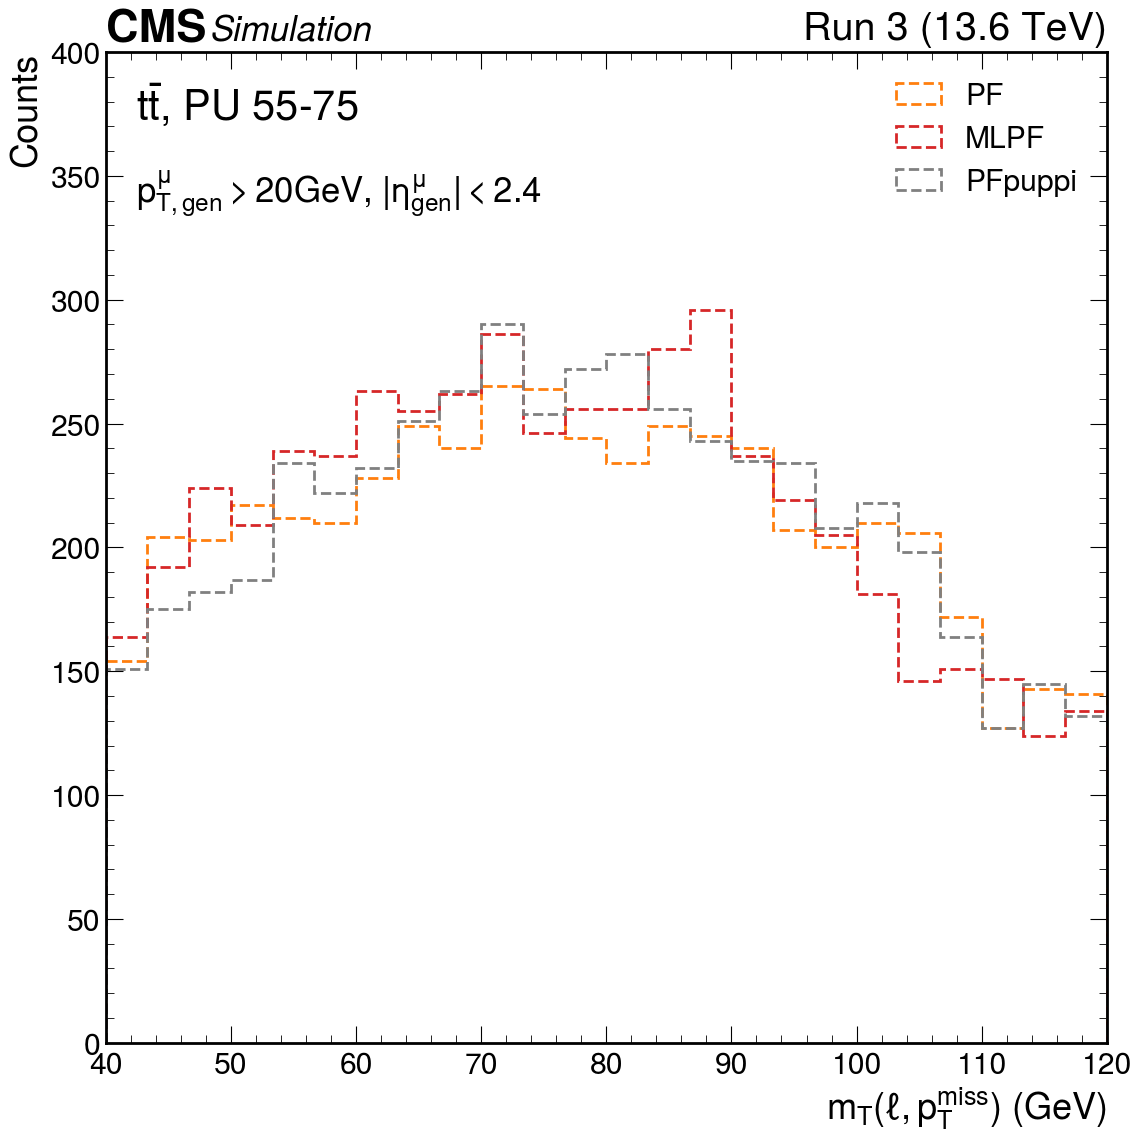

In [426]:
color_code = {
    "Gen": "tab:blue",
    "PF": "tab:orange",
    "MLPF": "tab:red",
}

bins = np.linspace(40,120,25)

fig, ax = plt.subplots(figsize=(12, 12))

# msk_dphi = out["PF"]["msk_dphi"]
# ax.hist(
#     out["PF"]["gen_mt"][msk_dphi].to_numpy().data,
#     bins=bins,
#     histtype="step",
#     lw=2,    
#     label="Gen", color=color_code["Gen"],
# )

for reco_label in ["PF", "MLPF"]:
    msk_dphi = out[reco_label]["msk_dphi"]
    ax.hist(
        out[reco_label]["pf_mt"][msk_dphi].to_numpy().data,
        bins=bins,
        histtype="step",
        lw=2,    
        label=reco_label, linestyle="--", color=color_code[reco_label],
    )

msk_dphi = out["PF"]["msk_dphi"]    
ax.hist(
    out["PFpuppi"]["pf_mt"][msk_dphi].to_numpy().data,
    bins=bins,
    histtype="step",
    lw=2,    
    label="PFpuppi", linestyle="--", color="grey",
)    

# Axis labels and styling
ax.set_xlabel(r"$m_T(\ell, p_T^{miss})$ (GeV)")
ax.set_ylabel("Counts")

ax.legend(loc="upper right")

# ax.set_yscale("log")
ax.set_ylim(0, 400)
ax.set_xlim(40, 120)

cms_label(ax)

if "qcd" in physics_process:
    sample_label(ax, physics_process, fontsize=24)
else:
    sample_label(ax, physics_process, fontsize=30)

# plt.text(0.03, 0.85, r"$p_{T,gen}^{miss}>20$GeV, $p_{T,gen}^{\ell}>20$GeV, $|\eta_{gen}^{\ell}|<2.4$", transform=ax.transAxes, fontsize=25)
# plt.text(0.03, 0.85, r"$p_{T,gen}^{\mu}>20$GeV, $|\eta_{gen}^{\mu}|<2.4$, $\Delta \phi(\mu_{gen}, p_{T,gen}^{miss})>\pi/4$", transform=ax.transAxes, fontsize=25)
plt.text(0.03, 0.85, r"$p_{T,gen}^{\mu}>20$GeV, $|\eta_{gen}^{\mu}|<2.4$", transform=ax.transAxes, fontsize=25)

os.makedirs(f"./plots/{folder}", exist_ok=True)

plt.tight_layout()

plt.savefig(f"./plots/{folder}/mT.pdf")

In [ ]:
# bins = np.linspace(1,400,100)

# for reco_label in ["PF", "MLPF"]:
#     fig, ax = plt.subplots(figsize=(14, 10))

#     # Make 2D histogram
#     h = ax.hist2d(
#         gen_met_p4[reco_label].pt, pf_met_p4[reco_label].pt,
#         bins=bins,
#         cmap="viridis",
#         norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=None)
#     )

#     # Axis labels and styling
#     ax.set_xlabel("Pythia $p_T^{\mathrm{miss}}$")
#     ax.set_ylabel(reco_label + r" $p_T^{\mathrm{miss}}$")

#     cb = fig.colorbar(h[3], ax=ax)
#     cb.set_label("Counts")

#     cms_label(ax)

#     plt.show()

# bins = np.linspace(-3,3,100)

# for reco_label in ["PF", "MLPF"]:
#     fig, ax = plt.subplots(figsize=(14, 10))

#     # Make 2D histogram
#     h = ax.hist2d(
#         gen_met_phi[msk_events_genlep], pf_met_p4[reco_label].phi,
# #         gen_met_p4[reco_label].phi, pf_met_p4[reco_label].phi,
#         bins=bins,
#         cmap="viridis",
#         norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=None)
#     )

#     # Axis labels and styling
#     ax.set_xlabel("Pythia $\phi^{\mathrm{miss}}$")
#     ax.set_ylabel(reco_label + r" $\phi^{\mathrm{miss}}$")

#     cb = fig.colorbar(h[3], ax=ax)
#     cb.set_label("Counts")

#     cms_label(ax)

#     plt.show()